In [28]:
%matplotlib widget

In [29]:
import numpy as np
import matplotlib.pyplot as plt 
#from scipy.special import ellipk, ellipe, elliprf, elliprj 
from scipy.integrate import quad
from scipy.spatial.transform import Rotation 
import scipy.optimize
import pandas as pd
import sklearn
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator 
 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import einops as eo
import joblib
import dill 
import time
from functools import partial

import sys





In [30]:
def ellipp(n, m):
    n, m = (np.asarray(x) for x in (n, m))
    if np.any(m >= 1):
        raise ValueError("m must be < 1")
    y = 1 - m
    rf = elliprf(0, y, 1)
    rj = elliprj(0, y, 1, 1 - n)
    return rf + rj * n / 3


def ellipc(kc, p, c, s):
    kc, p, c, s = (np.asarray(x, dtype = np.float64) for x in (kc, p, c, s))
    #print(p[p<=0])
    if np.any(kc==0):
        raise ValueError("kc cannot be 0.")
    errtol=1e-10
    k = np.abs(kc)

    pp = p.copy()
    cc = c.copy()
    ss = s.copy() 
    em = 1.
    cond = p>0 

    pp[cond] = np.sqrt(p[cond])
    ss[cond] = (s/pp)[cond]

    if np.any(~cond):
        f = kc[~cond]**2 
        q = 1 - f
        g = 1 - pp[~cond]
        f = f - pp[~cond]
        q = q*(ss[~cond]-c[~cond]*pp[~cond])
        pp[~cond] = np.sqrt(f/g)
        cc = (c[~cond]-ss[~cond])/g
        ss[~cond] = (-q/(pp[~cond]*g**2+cc*pp[~cond]))
    f = cc.copy()
    cc = cc + ss/pp
    g = k/pp
    ss = 2*(ss+f*g)
    pp = g + pp
    g = em
    em = k + em
    kk = k.copy()
    while(np.any(np.abs(g-k)>g*errtol)):
        k = 2*np.sqrt(kk)
        kk = k*em
        f = cc.copy()
        cc = cc + ss/pp
        g = kk/pp
        ss = 2*(ss+f*g)
        pp = g + pp
        g = em.copy()
        em = k + em
    return (np.pi/2)*(ss+cc*em)/(em*(em+pp))
        
def test_ellipc(n, k):
    m = k**2
    kc = np.sqrt(1-m)
    elliptic = np.array([ellipk(m), ellipe(m), ellipp(n, m)])
    arg1 = np.array([kc, kc, kc])
    arg2 = np.array([1, 1, -n+1])
    arg3 = np.array([1, 1, 1])
    arg4 = np.array([1, kc**2, 1])

    elliptic_results = ellipc(arg1, arg2, arg3, arg4)
    test_1 = np.allclose(elliptic, elliptic_results, 1e-7) 
    return test_1
    

def alpha(xi, rr, R):
    return R/(np.sqrt(xi**2 +(rr+R)**2 ))
def beta(xi, rr, R):
    return xi/(np.sqrt(xi**2 +(rr+R)**2 ))
def k(xi, rr, R):
    num = (xi**2 + (R-rr)**2)
    den = (xi**2 + (R+rr)**2)
    return np.sqrt(num/den)

def Br_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))

    xi_p, xi_m = zz+L, zz-L
    alpha_p, alpha_m = alpha(xi_p, rr, R), alpha(xi_m, rr, R)


    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Br = (M*R/np.pi)* (alpha_p*ellipc(kp, 1, 1, -1) - alpha_m*ellipc(km, 1, 1, -1))
    return Br

def Bz_polar_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))
    xi_p, xi_m = zz+L, zz-L
    beta_p, beta_m = beta(xi_p, rr, R), beta(xi_m, rr, R)
    gamma = (R-rr)/(R+rr)

    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Bz = (R*M/(np.pi*(rr+R))) * (beta_p*ellipc(kp, gamma**2, 1, gamma) - beta_m*ellipc(km, gamma**2, 1, gamma))
    return Bz


def Bxyz_func(xx, yy, zz, R=3, L=2, C=1e3):
    tt = np.arctan2(yy,xx)
    rr = np.sqrt(xx**2 + yy**2)
    Br = Br_func(rr, zz, R, L, C)
    Bx = Br * np.cos(tt)
    By = Br * np.sin(tt)
    Bz = Bz_polar_func(rr, zz, R, L, C)
    return Bx, By, Bz

#def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    Bx = Br * np.cos(tt)
#    return Bx

#def By_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    By = Br * np.sin(tt)
#    return By

#def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
#    rr = np.sqrt(xx**2 + yy**2)
#    Bz = Bz_polar_func(rr, zz, R, L, C)
#    return Bz

def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[0]

def By_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[1]

def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[2]

def Bx(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz


def Bx_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz

In [31]:
folder = "data/PIM_03202023"
file_name = "DataAvg.txt"
file = f"{folder}/{file_name}"

shape_points = {"i":7*10+1,"j": 7*10+1,"k": 6*5+2}

df = pd.read_csv(file).sort_values(["z", "y", "x"])

X = np.array(df.loc[:, "x":"z"]) # unpacks to x, y, z
M = np.array(df.loc[:, "Mx":"Mz"])
df


,Unnamed: 0,x,y,z,Mx,My,Mz,Mx_std,My_std,Mz_std
160572,160572,-7.0,-7.0,0.0,0.068558,0.418323,-1.930507,0.001319,0.001535,0.001424
49138,49138,-6.8,-7.0,0.0,0.068072,0.417397,-1.932107,0.001227,0.001572,0.001746
121046,121046,-6.6,-7.0,0.0,0.065018,0.416864,-1.932594,0.001270,0.001299,0.001559
52040,52040,-6.4,-7.0,0.0,0.059892,0.416069,-1.934286,0.001357,0.001475,0.001304
92501,92501,-6.2,-7.0,0.0,0.054047,0.415682,-1.934872,0.001380,0.001372,0.001505
...,...,...,...,...,...,...,...,...,...,...
115801,115801,6.2,7.0,6.2,-0.292032,-0.254717,-0.858372,0.001425,0.001259,0.001627
159086,159086,6.4,7.0,6.2,-0.296463,-0.252376,-0.853248,0.001262,0.001415,0.001377
98152,98152,6.6,7.0,6.2,-0.301324,-0.250497,-0.848621,0.001329,0.001920,0.001643
17969,17969,6.8,7.0,6.2,-0.304914,-0.248203,-0.842591,0.001185,0.001268,0.001478


In [32]:
import numpy as np
import magpylib as magpy
import pyvista as pv

pv.set_jupyter_backend('client') # improve rending in a jupyter notebook

coil1 = magpy.Collection()
#for z in np.linspace(-8, 8, 16):
#    winding = magpy.current.Loop(
#        current=100,
#        diameter=2,
#        position=(0,0,z),
#    )
#    coil1.add(winding)


grid = pv.UniformGrid(
    dimensions=list(shape_points.values()),
    spacing=(0.2, 0.2, 0.2),
    origin=(-5, -5, 0),
)

# compute B-field and add as data to grid
#grid['B'] = coil1.getB(grid.points)
grid['B'] = M
print(grid['B'].shape)

# compute field lines
seed = pv.Disc(inner=0.2, outer=2, r_res=10, c_res=63)
strl = grid.streamlines_from_source(
    seed,
    vectors='B',
    max_time=180,
    initial_step_length=0.01,
    integration_direction='both',
    progress_bar=True
)

# create plotting scene
pl = pv.Plotter()

# add field lines and legend to scene
legend_args = {
    'title': 'B [mT]',
    'title_font_size': 20,
    'color': 'black',
    'position_y': 0.25,
    'vertical': True,
}

# draw coils
# magpy.show(coil1, canvas=pl, backend='pyvista')

# add streamlines
pl.add_mesh(
    strl.tube(radius=.02),
    cmap="RdBu",
    scalar_bar_args=legend_args,
)
# display scene
pl.camera.position=(160, 10, -10)
pl.set_background("white")
pl.show()

(161312, 3)


Generating Streamlines: 100%|██████████████████████████████████████████████████████████████████████████████████[00:00<00:00]


Widget(value="<iframe src='http://localhost:43461/index.html?ui=P_0x7f9fe550a710_0&reconnect=auto' style='widt…

In [33]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import magpylib as magpy
from matplotlib.widgets import Slider, Button
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, interactive_output, HBox, VBox
from IPython.display import display

df_xy = (df[df["z"]==0]) 



M_magnitude = np.linalg.norm(eo.rearrange(M,"(i j k) c -> i j k c", **shape_points), axis=2)

cmap = plt.cm.viridis
norm = plt.Normalize(M_magnitude.min(), M_magnitude.max())

X_z = eo.rearrange(np.array(df_xy.loc[:, "x":"z"]), "(i j) c -> i j c", **shape_points)


M_z = eo.rearrange(np.array(df_xy.loc[:, "Mx":"Mz"]), "(i j) c -> i j c", **shape_points)
    
x = X_z[:, :, 0]
y = X_z[:, :, 1]

u = M_z[:, :, 1]
v = -M_z[:, :, 0]

EinopsError:  Error while processing rearrange-reduction pattern "(i j) c -> i j c".
 Input tensor shape: (5041, 3). Additional info: {'i': 71, 'j': 71, 'k': 32}.
 Axis k is not used in transform

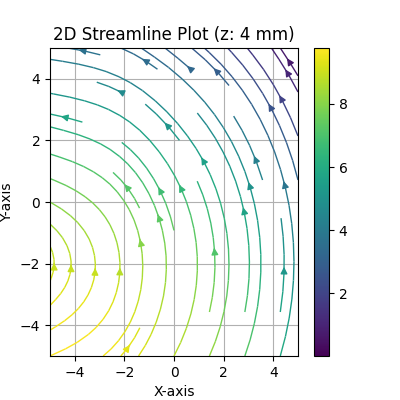

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
#fig.colorbar()

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
#@interact(z=FloatSlider(min=0, max=5, step=0.2, value=1.2, description='z (mm)'))
def plot_streamlines(z):
    df_xy = df[df["z"]==z] 
    X_z = eo.rearrange(np.array(df_xy.loc[:, "x":"z"]), "(i j) c -> i j c", i=shape_points[0], j=shape_points[1]) # unpacks to x, y, z
    M_z = eo.rearrange(np.array(df_xy.loc[:, "Mx":"Mz"]), "(i j) c -> i j c", i=shape_points[0], j=shape_points[1])
    
    
    x = X_z[:, :, 0]
    y = X_z[:, :, 1]

    u = M_z[:, :, 1]
    v = -M_z[:, :, 0]

    Mz_magnitude = np.linalg.norm(M_z, axis=2)
    
   
    
    
    
    ax.clear()
    ax.streamplot(x, y, u, v, density=0.5, linewidth=1, color=Mz_magnitude, cmap=cmap)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid()
    ax.set_title(f"2D Streamline Plot (z: {z} mm)")
    # Update the plot
    fig.canvas.draw_idle()
plot_streamlines(4)
    